In [17]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import math
from typing import List  # for the function annotation
from matplotlib import animation
from IPython.display import HTML

from Classes_and_Functions.classes import Pattern, Index
from Classes_and_Functions.functions import get_all_rotations, get_overlapping_tiles, valid_dirs, initialize_wave_function
from Classes_and_Functions.functions import is_fully_collapsed, get_possible_patterns_at_position, post_collasping


## Load sample and extract patterns


In [18]:
# initialise the input array for simplicity but we could've got them from pictures  by plt.imread() anyway
pixels = np.array([[255, 255, 255, 255], [255, 0, 0, 0],
                  [255, 0, 138, 0], [255, 0, 0, 0]])

# initialise this as 4x4 for simplicity but can easily find out using np.array.shape() method
input_size = (4, 4)
output_size = (50, 50)  # fixed output size
N = 2  # size of the patterns that will be considered in the Wavefunction Collapse Algorithm


[[255 255 255 255]
 [255   0   0   0]
 [255   0 138   0]
 [255   0   0   0]]


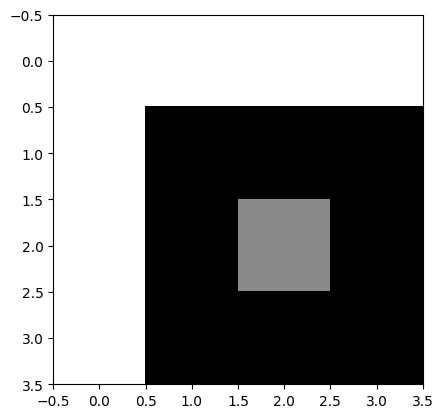

In [19]:
plt.imshow(pixels, cmap="gray")  # create plt
print(pixels)
plt.show()


Reading all possible patterns of size NxN from the input image and record their rotated patterns as the results will be shown below.

Function get_all_rotations() from functions.py and Pattern class from classes.py file were used.


In [20]:
patterns = []
# dict[pattern] -> count occurence which will be used to calculate the probabilities
weights = {}
probability = {}  # dict[pattern] -> probability

for y in range(input_size[0]-(N-1)):  # row
    for x in range(input_size[1]-(N-1)):  # column
        pattern = []
        for k in pixels[y:y+N]:
            # change array to int really quick
            pattern.append([int(i) for i in k[x:x+N]])
        pattern_rotations = get_all_rotations(pattern)

        for rotation in pattern_rotations:
            if rotation not in weights:
                weights[rotation] = 1
            else:
                # weights = count of occurences of the same pattern before rotations
                weights[rotation] += 1

        patterns.extend(pattern_rotations)

# remove duplicates
patterns_without_duplicates = []
for patt in patterns:
    if patt not in patterns_without_duplicates:
        patterns_without_duplicates.append(patt)
patterns = patterns_without_duplicates

sum_of_weights = 0
for weight in weights:
    sum_of_weights += weights[weight]

for pattern in patterns:
    # probability of each subpattern over total patterns after rotation
    probability[pattern] = weights[pattern] / sum_of_weights

# convert patterns from tuples into Pattern objects
patterns = [Pattern(p) for p in patterns]
weights = {pattern: weights[pattern.pixels] for pattern in patterns}
probability = {pattern: probability[pattern.pixels] for pattern in patterns}


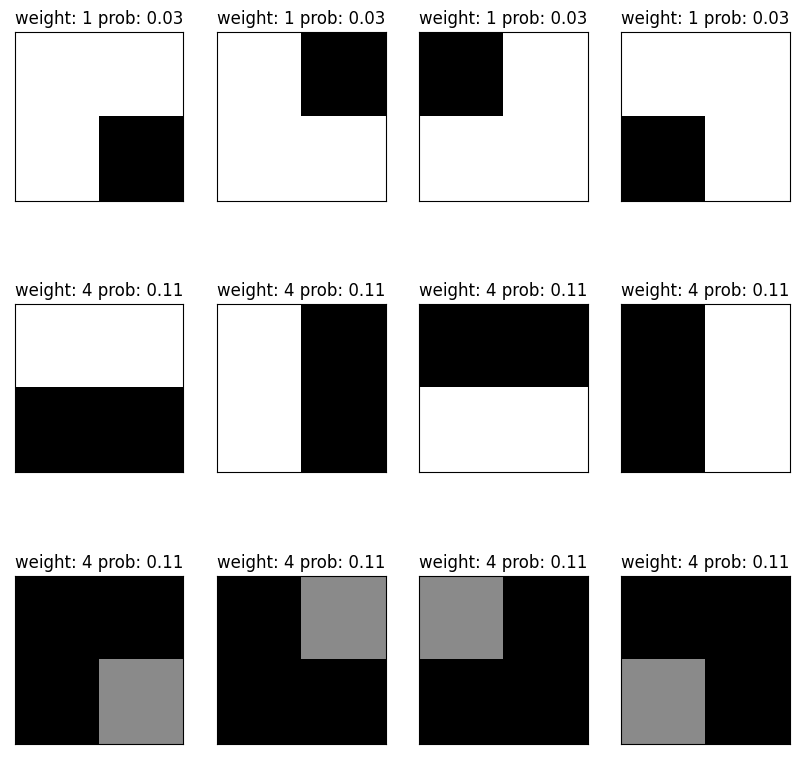

In [21]:
# show
plt.figure(figsize=(10, 10))
for m in range(len(patterns)):
    axs = plt.subplot(math.ceil(len(patterns)/4), 4, m+1)
    axs.imshow(patterns[m].pixels, cmap="gray", vmin=0, vmax=255)
    axs.set_xticks([])
    axs.set_yticks([])
    plt.title("weight: %.0f prob: %.2f" %
              (weights[patterns[m]], probability[patterns[m]]))
plt.show()


## Create Index data structure describing rules for placing patterns


In [22]:
UP = (0, -1)   # index of the pixel above relative to the pixel of interest
LEFT = (-1, 0)
DOWN = (0, 1)
RIGHT = (1, 0)
UP_LEFT = (-1, -1)
UP_RIGHT = (1, -1)
DOWN_LEFT = (-1, 1)
DOWN_RIGHT = (1, 1)
dirs = [UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT]


Index class tells which combinations of patterns are allowed for all patterns. get_overlapping_tiles() was imported from functions.py and used to figure the rules. 


In [24]:
# Initialise the index class for determining the allowed adjacent patterns
index = Index(patterns)

# Generate rules for Index and save them
# Function get_overlapping_tiles() from the functions file was used.

rules_num = 0
for pattern in patterns:
    for d in dirs:
        for pattern_next in patterns:
            # here's checking all offsets
            overlap = get_overlapping_tiles(pattern_next, d)
            # original direction is the opposite
            og_dir = tuple([d[0]*-1, d[1]*-1])
            part_of_og_pattern = get_overlapping_tiles(pattern, og_dir)
            if (overlap) == (part_of_og_pattern):
                index.add_rule(pattern, d, pattern_next)
                rules_num += 1


In [25]:
# Show data in Index for sanity check
print(f"There are {rules_num} rules")
"""
for d in index.data:
    print(f'Pattern {d.pixels}')
    for pos in index.data[d]:
        print(f' Pos {pos}')
        for pattern in index.data[d][pos]:
            print(f' {pattern.pixels}')
"""

# put it in as comments for simplicity in editing (the result is very long)
# The code works as intended so far


There are 360 rules


"\nfor d in index.data:\n    print(f'Pattern {d.pixels}')\n    for pos in index.data[d]:\n        print(f' Pos {pos}')\n        for pattern in index.data[d][pos]:\n            print(f' {pattern.pixels}')\n"

## Define coefficients


At the beginning, all available patterns are possible at all positions and what algorithm has to do is to reduce their number to only one pattern at each possition.

We start by defining matrix of tiles with corresponding possible patterns later called matrix of coefficients. In original implementation this holds boolean values denoting which pattern is still available. For simplicity we will use patterns themself to tell which are still possible in this position.

Gumin’s algorithm does not implement local backtracking and
instead globally restarts in the rare case a conflict is reached.


In [26]:
# initilize_wave_function

# will be updated to one pattern for each tile if the algorithn is fully complete
coefficients = initialize_wave_function(output_size, patterns)


# Algorithm itself


## Definition of Shannon entropy

For this notebook, we are using the minimum remaining values heuristic. Therefore, the shannon entropy is introduced here.
The bigger number of possible patterns for a tile, the bigger the "uncertainty" ,ie the entropy, is.
Tile where only one pattern is possible has entropy equal to 0.

For each iteration we need to start propagating our algorithm from the place with the lowest non zero entropy meaning level of “uncertainty” is the smallest.


$$ \huge H(X) = - \sum_{i=1}^{n}\ p_i \log_2 p_i $$


In [27]:
def get_shannon_entropy(position):
    """
    Calcualte the Shannon Entropy of the wavefunction at position (x, y)
    Retunr None for the case that the tile has no possible patterns 

    """
    x, y = position
    entropy = 0

    # A cell with one valid pattern has 0 entropy
    if len(coefficients[x][y]) == 1:
        return 0
    elif len(coefficients[x][y]) == 0:  # want to throw an error for this
        return None

    for pattern in coefficients[x][y]:
        # recall that probability is a dictionary of probabilities where the key is the corresponding pattern
        entropy -= probability[pattern] * math.log(probability[pattern], 2)

    # Add noise to break ties and near-ties
    entropy -= random.uniform(0, 0.1)
    return entropy


In [28]:
def get_min_entropy_pos():
    """
    Return position of tile with the lowest non-zero entropy for non fullly collapsed wavefunctions
    Return None for fully collapsed wavefunction

    """
    minEntropy = None  # since zero is meaningful had to resort to None
    minEntropyPos = None

    # x, y positions don't make sense but could be my brain is being daft
    for x, col in enumerate(coefficients):
        for y, row in enumerate(col):
            entropy = get_shannon_entropy((x, y))

            if entropy == 0:
                continue   # to skip the tiles with zero entropy
            elif entropy == None:
                return 0  # resort to zero as None is taken and zero is not going to be used anyway
            if minEntropy is None or entropy < minEntropy:
                minEntropy = entropy
                minEntropyPos = (x, y)
    return minEntropyPos


## Implement the minimum remaining value (MRV) heuristic


Since there usually is more than one valid pattern for the selected location, an option to collapse the wavefunction is to pick the pattern with the highest probability to appear in the input image. 


In [29]:
def observe():
    '''
    This function will be used to observe the position with minimum entropy
    ,and collapse the wavefunction at the position to one state based on the pattern with maximum probability.
    Tie will be chosen randomly by the random.choice() function. 
    It returns the position of the pixel with minimum entropy // convenient for passing the function as the argument of the Propagator() function
    Unless the wavefunction is fully collapsed-> print("All tiles have 0 entropy")  
    or contradiction was observed --> print("Contradiction was detetced. Rerun again sorry")  
    '''

    # Find the position of the tile with lowest entropy
    min_entropy_pos = get_min_entropy_pos()

    # min_entropy_pos == None satisfied when the wavefunction is fully collapsed.
    if min_entropy_pos == None:
        print("All tiles have 0 entropy")
        return

    # min_entropy_pos == 0 satisfied when a tile has no possible pattern (contradiction)
    elif min_entropy_pos == 0:
        print("Contradiction was detetced. Rerun again sorry")
        return min_entropy_pos

    # Choose a pattern at lowest entropy position which is most frequent in the sample
    possible_patterns = get_possible_patterns_at_position(
        min_entropy_pos, coefficients)

    # calculate max probability for patterns that are left
    max_p = 0
    for pattern in possible_patterns:
        if max_p < probability[pattern]:
            max_p == probability[pattern]

    semi_random_pattern = random.choice(
        [pat for pat in possible_patterns if probability[pat] >= max_p])

    # Set this pattern to be the only available at this position
    coefficients[min_entropy_pos[0]][min_entropy_pos[1]] = semi_random_pattern

    return min_entropy_pos


After a pattern has been assigned to a tile, we need to check if all of patterns in adjacent tiles are still possible in their locations. So it’s time to propagate. For every change we do in our matrix, we add tile position into a stack. For every adjacent tile, if there is a change, we add it’s position. If there is no change in neigbourhood tiles, we take tiles from stack, check for changes and add changed tiles positions into a stack and so on…


In [30]:
def propagate(min_entropy_pos):
    '''
    Update the coefficients of the neighbours
    '''
    stack = [min_entropy_pos]

    while len(stack) > 0:

        # list.pop() removes the element at the specified position... default is -1
        pos = stack.pop()

        # pos equals to the last element in the stack list and stack has one less member
        possible_patterns = get_possible_patterns_at_position(
            pos, coefficients)

        # Iterate through each location immediately adjacent to the current location
        for d in valid_dirs(pos, output_size):
            adjacent_pos = (pos[0] + d[0], pos[1] + d[1])
            possible_patterns_at_adjacent = get_possible_patterns_at_position(
                adjacent_pos, coefficients)

            # Iterate over all still available patterns in adjacent tile
            # and check if pattern is still possible in this location
            if not isinstance(possible_patterns_at_adjacent, list):
                possible_patterns_at_adjacent = [possible_patterns_at_adjacent]
            for possible_pattern_at_adjacent in possible_patterns_at_adjacent:
                if len(possible_patterns) > 1:
                    # any(iterable) function returns True if any item in the iterable are true otherwise False
                    is_possible = any([index.check_possibility(
                        pattern, possible_pattern_at_adjacent, d) for pattern in possible_patterns])
                else:
                    is_possible = index.check_possibility(
                        possible_patterns, possible_pattern_at_adjacent, d)

                '''
                If the tile is not compatible with any of the tiles in the current location's wavefunction
                then it's impossible for it to ever get choosen so it needs to be removed from the other
                location's wavefunction
                '''
                if not is_possible:
                    x, y = adjacent_pos
                    coefficients[x][y] = [patt for patt in coefficients[x][y]
                                          if patt.pixels != possible_pattern_at_adjacent.pixels]

                    if adjacent_pos not in stack:
                        stack.append(adjacent_pos)


## Wave function collapse


Putting observe(), propaget() and post_collasping() together to generate arrays of procedural content.

Note that the imported is_fully_collapsed() is also being used here.


In [31]:
frames = []  # set up list of frames for the animation

while not is_fully_collapsed(coefficients):
    min_entropy_pos = observe()  # Collasping the wavefunction

    # correspond to when contradiction was detected
    if min_entropy_pos == 0:
        break

    # Get the array after each collaspe ready for animation
    frames.append(post_collasping(coefficients))

    propagate(min_entropy_pos)  # Updating the coefficients elements



## Animation


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


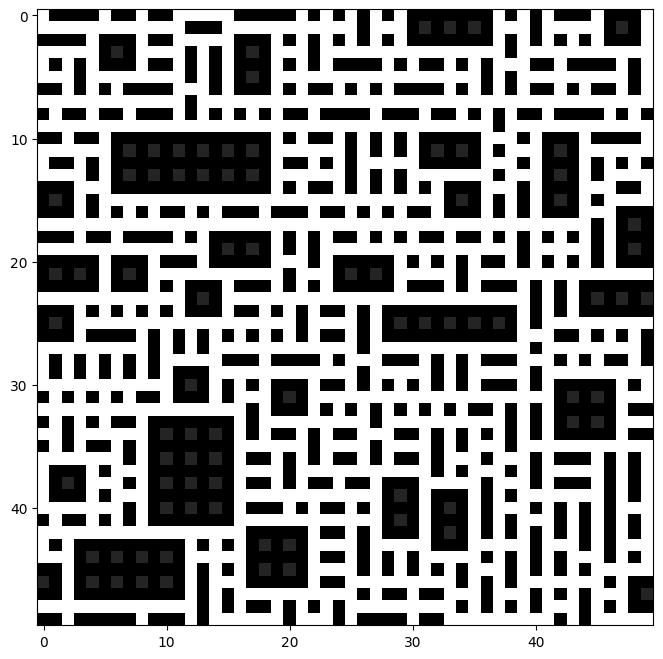

In [32]:
# First set up the figure, the axis, and the plot element we want to animate

fig = plt.figure(figsize=(8, 8))    
a = frames[0]
im = plt.imshow(a, cmap='gray')


def animate_func(i):
    im.set_array(frames[i])
    return [im]


anim = animation.FuncAnimation(
    fig,
    animate_func,
    frames=len(frames),
    interval=5000/len(frames),     # want an animation of 5000 millisecs
)

fps = len(frames)/5

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())


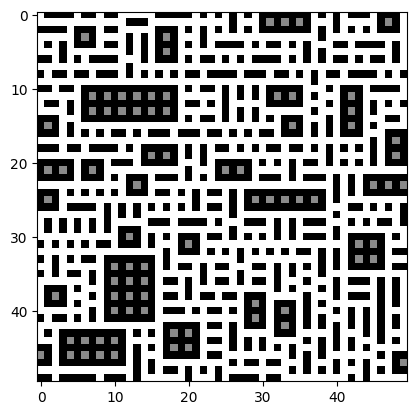

In [33]:
plt.imshow(post_collasping(coefficients), cmap="gray")
plt.show()
